### Import Libraries

In [ ]:
import re
import pandas as pd
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.chunk import RegexpParser
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# read data

data = pd.read_excel('isco.xlsx')
data = data[data["Level"].apply(lambda x: x == 4)]
data = data[["ISCO 08 Code", "Title EN", "Tasks include"]]
data.head()

,ISCO 08 Code,Title EN,Tasks include
3,1111,Legislators,Tasks include -\n(a) presiding over or partic...
4,1112,Senior Government Officials,"Tasks include -\n(a) advising national, state..."
5,1113,Traditional Chiefs and Heads of Villages,Tasks include -\n(a) allocating the use of co...
6,1114,Senior Officials of Special-interest Organizat...,Tasks include -\n(a) determining and formulat...
8,1120,Managing Directors and Chief Executives,"Tasks include -\n(a) planning, directing and ..."


### Preprocessing

In [ ]:
# check missing value

print(data.isna().sum())

ISCO 08 Code     0
Title EN         0
Tasks include    9
dtype: int64


In [ ]:
# remove missing value (tidak perlu karena kolom title and abstract tidak memiliki missing value)

data.dropna(inplace=True)
data.head()

,ISCO 08 Code,Title EN,Tasks include
3,1111,Legislators,Tasks include -\n(a) presiding over or partic...
4,1112,Senior Government Officials,"Tasks include -\n(a) advising national, state..."
5,1113,Traditional Chiefs and Heads of Villages,Tasks include -\n(a) allocating the use of co...
6,1114,Senior Officials of Special-interest Organizat...,Tasks include -\n(a) determining and formulat...
8,1120,Managing Directors and Chief Executives,"Tasks include -\n(a) planning, directing and ..."


In [ ]:
# Define the substrings to remove
to_remove = ["Tasks include -\n",
             "Tasks include - \n",
             "Tasks include –\n",
             "Tasks include – \n",
             "In such cases tasks would include:\n",
             "In such cases tasks would include: \n",
             "In such cases tasks would include -\n",
             "In such cases tasks would include - \n",
             "In such instances tasks would include -\n",
             "In such instances tasks would include - \n",
             "(a)  ", "(b)  ", "(c)  ", "(d)  ", "(e)  ", "(f)  ", "(g)  ", "(h)  ", "(i)  ", "(j)  ", "(k)  ", "(l)  ", "(m)  ", "(n)  ",
             "(a) ", "(b) ", "(c) ", "(d) ", "(e) ", "(f) ", "(g) ", "(h) ", "(i) ", "(j) ", "(k) ", "(l) ", "(m) ", "(n) "
             ]

# Replace the substrings with an empty string
for substring in to_remove:
    data['Tasks include'] = data['Tasks include'].apply(lambda x: x.replace(substring, ''))

data.head()

,ISCO 08 Code,Title EN,Tasks include
3,1111,Legislators,presiding over or participating in the proceed...
4,1112,Senior Government Officials,"advising national, state, regional or local go..."
5,1113,Traditional Chiefs and Heads of Villages,allocating the use of communal land and other ...
6,1114,Senior Officials of Special-interest Organizat...,"determining and formulating the policies, rule..."
8,1120,Managing Directors and Chief Executives,"planning, directing and coordinating the gener..."


In [ ]:
# lowering text
data['lowered']= data['Tasks include'].apply(lambda x: x.lower())

# Print the updated DataFrame
data['lowered'].head()

3    presiding over or participating in the proceed...
4    advising national, state, regional or local go...
5    allocating the use of communal land and other ...
6    determining and formulating the policies, rule...
8    planning, directing and coordinating the gener...
Name: lowered, dtype: object

In [ ]:
# Function to tokenize each sentence, tokenize each word from sentence, then remove punctuation and sopword
def tokenize_and_remove_punctuation(text):
    # Define stopword
    stop_words = set(stopwords.words('english'))

    # Tokenize each sentence
    sentences = re.split(r'\n', text)

    # Tokenize each word in each sentence, remove punctuation, and remove stopword
    tokenized_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        # Remove punctuation
        tokens = [token for token in tokens if token not in string.punctuation]
        # Remove stopword
        tokens = [token for token in tokens if token not in stop_words]
        tokenized_sentences.append(tokens)
    return tokenized_sentences

# Tokenize each sentence and remove punctuation & stopword
data['tokenized'] = data['lowered'].apply(tokenize_and_remove_punctuation)

# Print the updated DataFrame
data.head()

,ISCO 08 Code,Title EN,Tasks include,lowered,tokenized
3,1111,Legislators,presiding over or participating in the proceed...,presiding over or participating in the proceed...,"[[presiding, participating, proceedings, legis..."
4,1112,Senior Government Officials,"advising national, state, regional or local go...","advising national, state, regional or local go...","[[advising, national, state, regional, local, ..."
5,1113,Traditional Chiefs and Heads of Villages,allocating the use of communal land and other ...,allocating the use of communal land and other ...,"[[allocating, use, communal, land, resources, ..."
6,1114,Senior Officials of Special-interest Organizat...,"determining and formulating the policies, rule...","determining and formulating the policies, rule...","[[determining, formulating, policies, rules, r..."
8,1120,Managing Directors and Chief Executives,"planning, directing and coordinating the gener...","planning, directing and coordinating the gener...","[[planning, directing, coordinating, general, ..."


### POS Tag

In [ ]:
# # Function to perform POS tagging on each token
# def pos_tag_tokens(tokenized_sentences):
#     pos_tagged_sentences = []
#     for sentence_tokens in tokenized_sentences:
#         pos_tags = pos_tag(sentence_tokens)
#         pos_tagged_sentences.append(pos_tags)
#     return pos_tagged_sentences

# # Perform POS tagging on tokenized sentences
# data['pos_tagged'] = data['tokenized'].apply(pos_tag_tokens)

# # Print the updated DataFrame
# data.head()

In [ ]:
import spacy

# Load the spaCy model with Penn Treebank tag set
nlp = spacy.load("en_core_web_sm")

# Function to perform POS tagging on each token using spaCy
def pos_tag_spacy(text):
    doc = nlp(" ".join(text))
    return [(token.text, token.tag_) for token in doc]

data['pos_tagged_spacy'] = data['tokenized'].apply(lambda x: [pos_tag_spacy(sublist) for sublist in x])
data.head()

,ISCO 08 Code,Title EN,Tasks include,lowered,tokenized,pos_tagged_spacy
3,1111,Legislators,presiding over or participating in the proceed...,presiding over or participating in the proceed...,"[[presiding, participating, proceedings, legis...","[[(presiding, VBG), (participating, VBG), (pro..."
4,1112,Senior Government Officials,"advising national, state, regional or local go...","advising national, state, regional or local go...","[[advising, national, state, regional, local, ...","[[(advising, VBG), (national, JJ), (state, NN)..."
5,1113,Traditional Chiefs and Heads of Villages,allocating the use of communal land and other ...,allocating the use of communal land and other ...,"[[allocating, use, communal, land, resources, ...","[[(allocating, VBG), (use, NN), (communal, JJ)..."
6,1114,Senior Officials of Special-interest Organizat...,"determining and formulating the policies, rule...","determining and formulating the policies, rule...","[[determining, formulating, policies, rules, r...","[[(determining, VBG), (formulating, NN), (poli..."
8,1120,Managing Directors and Chief Executives,"planning, directing and coordinating the gener...","planning, directing and coordinating the gener...","[[planning, directing, coordinating, general, ...","[[(planning, VBG), (directing, NN), (coordinat..."


In [ ]:
# Function to lemmatize tokens
def lemmatize_tokens(pos_tagged_sentences):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentences = []
    for sentence_tags in pos_tagged_sentences:
        lemmatized_tokens = [(lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos_tag)), pos_tag) for token, pos_tag in sentence_tags]
        lemmatized_sentences.append(lemmatized_tokens)
    return lemmatized_sentences

# Function to map POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN  # Default to noun if POS tag not recognized

# Lemmatize the tokens in 'pos_tagged_sentences' column
data['lemmatized'] = data['pos_tagged_spacy'].apply(lemmatize_tokens)

# Print the updated DataFrame
data.head()

,ISCO 08 Code,Title EN,Tasks include,lowered,tokenized,pos_tagged_spacy,lemmatized
3,1111,Legislators,presiding over or participating in the proceed...,presiding over or participating in the proceed...,"[[presiding, participating, proceedings, legis...","[[(presiding, VBG), (participating, VBG), (pro...","[[(preside, VBG), (participate, VBG), (proceed..."
4,1112,Senior Government Officials,"advising national, state, regional or local go...","advising national, state, regional or local go...","[[advising, national, state, regional, local, ...","[[(advising, VBG), (national, JJ), (state, NN)...","[[(advise, VBG), (national, JJ), (state, NN), ..."
5,1113,Traditional Chiefs and Heads of Villages,allocating the use of communal land and other ...,allocating the use of communal land and other ...,"[[allocating, use, communal, land, resources, ...","[[(allocating, VBG), (use, NN), (communal, JJ)...","[[(allocate, VBG), (use, NN), (communal, JJ), ..."
6,1114,Senior Officials of Special-interest Organizat...,"determining and formulating the policies, rule...","determining and formulating the policies, rule...","[[determining, formulating, policies, rules, r...","[[(determining, VBG), (formulating, NN), (poli...","[[(determine, VBG), (formulating, NN), (policy..."
8,1120,Managing Directors and Chief Executives,"planning, directing and coordinating the gener...","planning, directing and coordinating the gener...","[[planning, directing, coordinating, general, ...","[[(planning, VBG), (directing, NN), (coordinat...","[[(plan, VBG), (directing, NN), (coordinate, V..."


### POS Chunk

In [ ]:
# define pattern
pattern_siahaan = r'''Chunk: {<VB\w*>+<.|IN|CC|PRP\w*>*<DT>*<NN\w*|RB>+}'''
pattern_webb = r'''Chunk: {<VB\w*><NN\w*>}'''
pattern_johann = r'''Chunk: {<VB\w*><NN\w*>|<VB\w*><PRP\w*><NN\w*>|<VB\w*><NN\w*><NN\w*>|<VB\w*><JJ\w*><NN\w*>|<VB\w*><DT><NN\w*>|<VB\w*><NN\w*><IN><NN\w*>|<VB\w*><IN><JJ\w*><NN\w*>|<VB\w*><PRP\w*><JJ\w*><NN\w*>}'''
new_pattern = r'''Chunk: {<VB\w*>+<PRP\w*|JJ\w*|DT|IN|CC|.>*<NN\w*>+}'''

def extract(tagged_texts, pattern):
    chunk_parser = RegexpParser(pattern)
    chunks = []
    for tagged_text in tagged_texts:
        tree = chunk_parser.parse(tagged_text)
        tree = extract_chunks(tree)
        tree = trees_to_tuples(tree)
        chunks.append(tree)
    chunks = [item for sublist in chunks for item in sublist]
    return chunks

def extract_chunks(tree):
    chunks = []

    if isinstance(tree, nltk.Tree):
        if tree.label() != 'S':  # Exclude sentence-level chunks if any
            chunks.append(tree)
        for subtree in tree:
            chunks.extend(extract_chunks(subtree))

    return chunks

def trees_to_tuples(tree_list):
    # tuple_list = [tuple(leaf[0] for leaf in tree.leaves()) for tree in tree_list]
    tuple_list = [[[(leaf[0], leaf[1]) for leaf in tree.leaves()] for tree in tree_list]]
    return tuple_list

# Apply chunking and extraction to the 'tagged_sentences' column
data['pattern_webb'] = data['lemmatized'].apply(lambda x: extract(x, pattern_webb))
data['pattern_siahaan'] = data['lemmatized'].apply(lambda x: extract(x, pattern_siahaan))
data['pattern_johann'] = data['lemmatized'].apply(lambda x: extract(x, pattern_johann))
data['new_pattern'] = data['lemmatized'].apply(lambda x: extract(x, new_pattern))

# Print the resulting DataFrame with chunked data
data['pattern_webb'][3]

[[[('participate', 'VBG'), ('proceeding', 'NNS')]],
 [[('determine', 'VBG'), ('formulating', 'NN')],
  [('direct', 'VBG'), ('policy', 'NNS')]],
 [[('repeal', 'VBG'), ('law', 'NNS')]],
 [[('serve', 'VBG'), ('government', 'NN')]],
 [[('investigate', 'VBG'), ('matter', 'NNS')],
  [('promote', 'VBG'), ('interest', 'NNS')]],
 [[('attend', 'VBG'), ('community', 'NN')],
  [('provide', 'VBP'), ('service', 'NN')],
  [('provide', 'VB'), ('information', 'NN')]],
 [[('negotiate', 'VBG'), ('legislator', 'NNS')],
  [('representatives', 'VBZ'), ('interest', 'NN')],
  [('differ', 'VBG'), ('interest', 'NNS')],
  [('create', 'VBP'), ('policy', 'NNS')]],
 []]

### Visualize The result

In [ ]:
# count the number of keyword

occupation_task_siahaan = data['pattern_siahaan'].apply(pd.Series).stack().tolist()
occupation_task_webb = data['pattern_webb'].apply(pd.Series).stack().tolist()
occupation_task_johann = data['pattern_johann'].apply(pd.Series).stack().tolist()
occupation_task_new_pattern = data['new_pattern'].apply(pd.Series).stack().tolist()

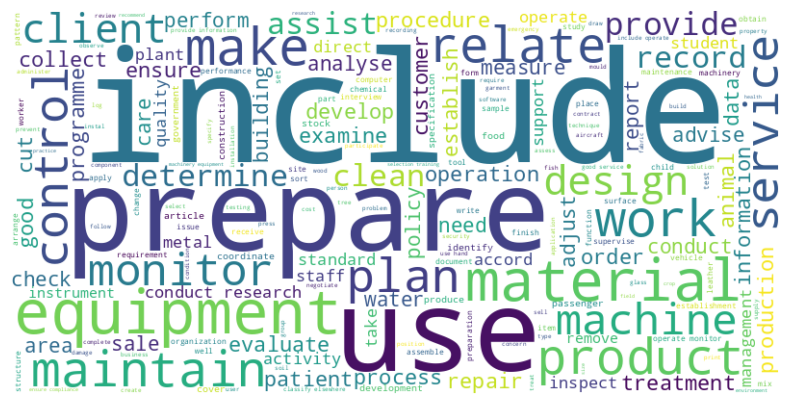

In [ ]:
# Wordcloud Occupation Abilities Siahaan

# Flatten the list of tuples to get a single list of strings
words = [word for tuple_ in occupation_task_siahaan for word in tuple_]

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

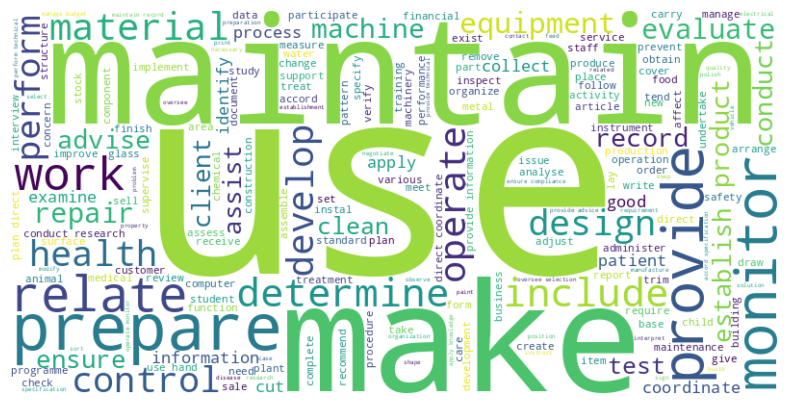

In [ ]:
# Wordcloud Occupation Abilities Johann

# Flatten the list of tuples to get a single list of strings
words = [word for tuple_ in occupation_task_johann for word in tuple_]

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


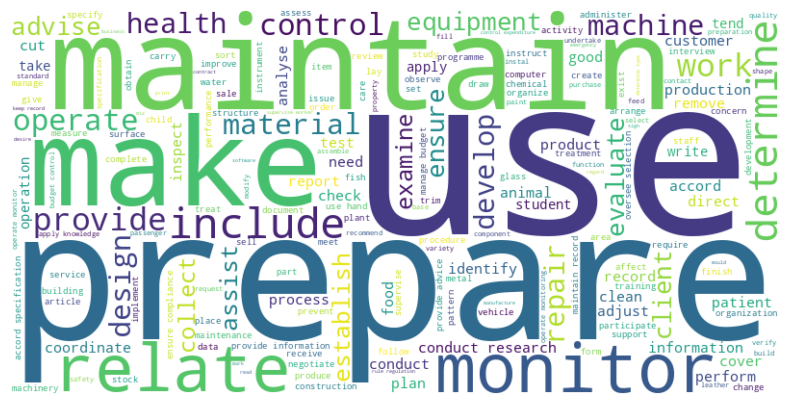

In [ ]:
# Wordcloud Occupation Abilities Webb

# Flatten the list of tuples to get a single list of strings
words = [word for tuple_ in occupation_task_webb for word in tuple_]

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


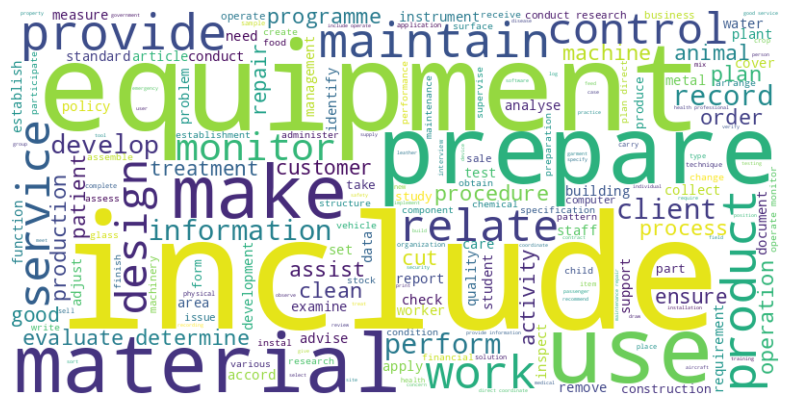

In [ ]:
# Wordcloud Occupation Abilities new_pattern

# Flatten the list of tuples to get a single list of strings
words = [word for tuple_ in occupation_task_new_pattern for word in tuple_]

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Export Result

In [ ]:
# hasile

# patent_task = data[["Title EN", "definition_and_task", "pattern_webb", "pattern_siahaan", "pattern_johann"]]
data.to_excel('extraction_result_isco.xlsx', index=False)